# Test of correct frequency normalization


In [20]:
%matplotlib inline
import numpy as np
from NuRadioMC.utilities import fft
from NuRadioMC.utilities import units
import NuRadioMC.SignalGen.RalstonBuniy.askaryan_module as AskaryanModule

the fft utility module implements a real fft with a normalization so that
Plancherel theorem is valid. This means that the fourier transform must be unitary,
which is achieved by normalizing both transforms with 1/sqrt(n) and an additional
factor of sqrt(2) because negative frequencies are omitted in the real FFT.
This means that the power calculated in the time domain is the same as the
power calculated in the frequency domain.

One test of a correct frequency normalization of the signal generation modules is that the amplitude in the time domain should not depend on the frequency resolution, i.e., the number of samples in the time domain. 

We first implement a simple toy model with a constant amplitude for all frequencies of 1 / MHz. 

In [21]:
# we first calculate the maximum amplitude in the time domain for a
# normalization with (df/1MHz)**0.5 and (df/1MHz)
# for a 2**10 number of samples
dt = 0.1 * units.ns
n_trace = 2 ** 10  # samples of trace
tt = np.arange(0, n_trace * dt, dt)
ff = np.fft.rfftfreq(n_trace, dt)
df = ff[1] - ff[0]
print('number of samples = {} with a sampling of {:.1f}GHz result in a frequency bin width of {:.1f}MHz'.format(n_trace, 1./dt/units.GHz, df/units.MHz))

spectrum = np.ones(len(ff), dtype=np.complex)
spectrum[0] = 0  # set zero frequency bin to zero (no dc offset)
spectrum *= (df / units.MHz) ** 0.5
trace = fft.freq2time(spectrum)
print("-> max amplitude with sqrt(df) normalization = {:.2g}".format(np.abs(trace).max()))

spectrum = np.ones(len(ff), dtype=np.complex)
spectrum[0] = 0  # set zero frequency bin to zero (no dc offset)
spectrum *= (df / units.MHz)
trace = fft.freq2time(spectrum)
print("-> max amplitude with df normalization = {:.2g}".format(np.abs(trace).max()))

number of samples = 1024 with a sampling of 10.0GHz result in a frequency bin width of 9.8MHz
-> max amplitude with sqrt(df) normalization = 71
-> max amplitude with df normalization = 2.2e+02


In [22]:
# now we repeat the above calculation but with 2**14 number of samples. The maximum 
# amplitude in the time domain shoud remain the same for the correct frequency normalization. 

dt = 0.1 * units.ns
n_trace = 2 ** 14  # samples of trace
tt = np.arange(0, n_trace * dt, dt)
ff = np.fft.rfftfreq(n_trace, dt)
df = ff[1] - ff[0]
print('number of samples = {} with a sampling of {:.1f}GHz result in a frequency bin width of {:.1f}MHz'.format(n_trace, 1./dt/units.GHz, df/units.MHz))

spectrum = np.ones(len(ff), dtype=np.complex)
spectrum[0] = 0  # set zero frequency bin to zero (no dc offset)
spectrum *= (df / units.MHz) ** 0.5
trace = fft.freq2time(spectrum)
print("-> max amplitude with sqrt(df) normalization = {:.2g}".format(np.abs(trace).max()))

spectrum = np.ones(len(ff), dtype=np.complex)
spectrum[0] = 0  # set zero frequency bin to zero (no dc offset)
spectrum *= (df / units.MHz)
trace = fft.freq2time(spectrum)
print("-> max amplitude with df normalization = {:.2g}".format(np.abs(trace).max()))

number of samples = 16384 with a sampling of 10.0GHz result in a frequency bin width of 0.6MHz
-> max amplitude with sqrt(df) normalization = 71
-> max amplitude with df normalization = 55


This small test showed that the correct normalization should be using the square root of the frequency bin width, i.e. (df/1MHz)**0.5


## test of wrapper around Askaryan module
In the NuRadioMC implementation we only interface the function to generate the frequency spectrum. We obtain the time domain representation by normalizing the frequency spectrum correctly and applying an inverse FFT with a proper normalization. The following code checks that the amplitudes in the time domain do not depend on the number of samples:


In [23]:
E = 1e17 * units.eV
n_index = 1.78
theta = np.arccos(1. / n_index) + 2.5 * units.deg
R = 5 * units.km
dt = 0.1 * units.ns


n_trace = 2 ** 10  # samples of trace
tt = np.arange(0, n_trace * dt, dt)
ff = np.fft.rfftfreq(n_trace, dt)

trace = AskaryanModule.get_time_trace(E, theta, ff, 0, n=1.78, R=R)
print('Askaryan modules: maximum amplitude for {:d} samples is: {:4g}V/m'.format(n_trace, np.abs(trace).max()/units.V*units.m))

Askaryan modules: maximum amplitude for 1024 samples is: 1.51874e-06V/m


In [24]:
n_trace = 2 ** 12  # samples of trace
tt = np.arange(0, n_trace * dt, dt)
ff = np.fft.rfftfreq(n_trace, dt)

trace = AskaryanModule.get_time_trace(E, theta, ff, 0, n=1.78, R=R)
print('Askaryan modules: maximum amplitude for {:d} samples is: {:4g}V/m'.format(n_trace, np.abs(trace).max()/units.V*units.m))

Askaryan modules: maximum amplitude for 4096 samples is: 1.51873e-06V/m


the amplidues agree and thus do not depend on the frequency resolution, which shows that the frequency spectrum was normalized correctly to the frequency bin width. 

## test how amplitudes in frequency domain change with tracelength

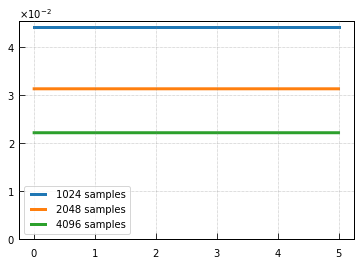

In [28]:
import matplotlib.pyplot as plt
dt = 0.1 * units.ns
n_trace = 2 ** 10  # samples of trace
ff = np.fft.rfftfreq(n_trace, dt)
trace_1 = np.zeros(n_trace)
trace_1[n_trace//2] = 1
spectrum_1 = fft.time2freq(trace_1)

fig, ax = plt.subplots(1, 1)
ax.plot(ff, np.abs(spectrum_1), label='{} samples'.format(n_trace))

n_trace = 2 ** 11  # samples of trace
ff = np.fft.rfftfreq(n_trace, dt)
trace_2 = np.zeros(n_trace)
trace_2[n_trace//2] = 1
spectrum_2 = fft.time2freq(trace_2)
ax.plot(ff, np.abs(spectrum_2), label='{} samples'.format(n_trace))

n_trace = 2 ** 12  # samples of trace
ff = np.fft.rfftfreq(n_trace, dt)
trace_2 = np.zeros(n_trace)
trace_2[n_trace//2] = 1
spectrum_2 = fft.time2freq(trace_2)
ax.plot(ff, np.abs(spectrum_2), label='{} samples'.format(n_trace))
ax.set_ylim(0)
ax.legend()
plt.show()


The above plot shows that the amplitudes A in the frequency domain drop by 1/sqrt(n_samples). As df is proportional to n_samples, A ~ 1/df, i.e. normalizing the frequency spectrum with the square root of the bin width seems to be the right choice. 